# Building a Model to Predict Fatality

# Load all Necesssary Packages

In [87]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import f1_score
from sklearn.feature_selection import SelectKBest, f_classif
import lightgbm as lgb
import statsmodels.api as sm
import shap

# Load data generated from RTI_data_exercise_text_analytics code

In [2]:
combined_data = pd.read_csv('Downloads/combined_aviation_data_topic_nums.csv')

## Only Keep Variables with <50% Missing and that are descriptive of flight

In [4]:
combined_data= combined_data[['AccidentNumber', 'FatalIndicator', 'Country', 'AirportCode', 'AirportName',
                              'Make','Model','AmateurBuilt','NumberOfEngines','EngineType',
                              'PurposeOfFlight','WeatherCondition','BroadPhaseOfFlight','Year','Month','Day','WeekDay',
                              'topic_num_narrative','topic_num_cause']]

In [5]:
#fillna with missing to perform encoding
combined_data= combined_data.fillna('missing')

In [98]:
combined_data.head()
combined_data['WeatherCondition'].value_counts()

VMC        68764
IMC         5580
missing     1985
UNK          924
Name: WeatherCondition, dtype: int64

## Label Encode Categorical Variables

In [6]:
cat_features = ['Country', 'AirportCode', 'AirportName',
                'Make','Model','AmateurBuilt','EngineType',
                'PurposeOfFlight','WeatherCondition','BroadPhaseOfFlight']
encoder = LabelEncoder()
encoded = combined_data[cat_features].apply(encoder.fit_transform)

In [7]:
encoded_data = pd.concat([encoded, combined_data[combined_data.columns.difference(encoded.columns)]], axis=1)

In [97]:
encoded_data.head()
encoded_data['WeatherCondition'].value_counts()

2    68764
0     5580
3     1985
1      924
Name: WeatherCondition, dtype: int64

## Impute missing values for number of engines

In [8]:
encoded_data['NumberOfEngines'] = encoded_data['NumberOfEngines'].replace('missing',0.8425)

## Split Data into Feature and Target Columns

In [9]:
AccidentNumber = encoded_data['AccidentNumber']
encoded_data_no_id = encoded_data.drop(columns = ['AccidentNumber'])
X = encoded_data_no_id.drop(columns = ['FatalIndicator'])
y = encoded_data_no_id['FatalIndicator']

## Get Dummy Variables for Feature Columns

In [17]:
X_dummies = pd.get_dummies(X, prefix = X.columns, columns = X.columns, drop_first = True)

## Split into Train and Test Data Sets

In [19]:
X_train, X_test, y_train, y_test = train_test_split(X_dummies, y, test_size=0.30)

## Select 50 Most important Variables using Anova F-Value

In [24]:
selector = SelectKBest(score_func=f_classif, k=50)
X_train_new = selector.fit_transform(X_train ,y_train)

/Users/Rachel/opt/anaconda3/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [   48    61    66 ... 50263 50264 50273] are constant.
  UserWarning)
/Users/Rachel/opt/anaconda3/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:115: RuntimeWarning: divide by zero encountered in true_divide
  f = msb / msw
/Users/Rachel/opt/anaconda3/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:115: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw


In [26]:
selected_features = pd.DataFrame(selector.inverse_transform(X_train_new), 
                                 index=X_train.index, 
                                 columns=X_train.columns)

In [28]:
selected_columns = selected_features.columns[selected_features.var() != 0]

In [29]:
selected_columns

Index(['Country_9', 'Country_23', 'Country_29', 'Country_34', 'Country_55',
       'Country_60', 'Country_66', 'Country_106', 'Country_134', 'Country_164',
       'AirportCode_7155', 'AirportCode_9478', 'AirportName_22268', 'Make_572',
       'Make_680', 'Make_908', 'Make_1148', 'Model_194', 'Model_2088',
       'AmateurBuilt_1', 'EngineType_5', 'EngineType_9', 'EngineType_14',
       'PurposeOfFlight_5', 'PurposeOfFlight_12', 'PurposeOfFlight_14',
       'WeatherCondition_1', 'WeatherCondition_2', 'WeatherCondition_3',
       'BroadPhaseOfFlight_1', 'BroadPhaseOfFlight_2', 'BroadPhaseOfFlight_5',
       'BroadPhaseOfFlight_6', 'BroadPhaseOfFlight_9', 'BroadPhaseOfFlight_10',
       'BroadPhaseOfFlight_11', 'BroadPhaseOfFlight_12', 'Month_11.0',
       'Month_12.0', 'NumberOfEngines_0.8425', 'NumberOfEngines_1.0',
       'NumberOfEngines_2.0', 'NumberOfEngines_3.0', 'topic_num_cause_1',
       'topic_num_cause_2', 'topic_num_cause_3', 'topic_num_cause_4',
       'topic_num_narrative_1'

## Subset Data to Only Most Import Variables

In [59]:
X_dummies_imp = X_dummies.iloc[:, 50164:50318]
X_dummies_imp = X_dummies_imp.loc[:,~X_dummies_imp.columns.str.startswith('Year')]
X_dummies_imp = X_dummies_imp.loc[:,~X_dummies_imp.columns.str.startswith('Day')]
X_dummies_imp = X_dummies_imp.loc[:,~X_dummies_imp.columns.str.startswith('WeekDay')]

In [60]:
X_train, X_test, y_train, y_test = train_test_split(X_dummies_imp, y, test_size=0.30)

# Train a logistic Regression on the Data

In [62]:
logistic = LogisticRegression(penalty='l2', C = 1, random_state = 7)
logistic.fit(X_train, y_train)

/Users/Rachel/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


LogisticRegression(C=1, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=7, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [83]:
print('Logistic Validation Results')
print('AUC:',roc_auc_score(y_test, logistic.predict(X_test)))

Logistic Validation Results
AUC: 0.7293283043568319


## Get Coefficient Values

In [ ]:
#Amateur Built is bad!
#Reciprocating engine bad!
#Personal and Business flights bad!

In [57]:
y_train = y_train.astype(int)
logit_model=sm.Logit(y_train,X_train)
result=logit_model.fit(method='bfgs')
print(result.summary2())

         Current function value: 0.326714
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36
                                      Results: Logit
Model:                        Logit                    Pseudo R-squared:         0.348     
Dependent Variable:           FatalIndicator           AIC:                      35487.4467
Date:                         2020-02-04 10:30         BIC:                      36163.7072
No. Observations:             54077                    Log-Likelihood:           -17668.   
Df Model:                     75                       LL-Null:                  -27100.   
Df Residuals:                 54001                    LLR p-value:              0.0000    
Converged:                    0.0000                   Scale:                    1.0000    
-------------------------------------------------------------------------------------------
                        Coef.     Std.Err.      z     P>|z|       [0.025     

/Users/Rachel/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


# Train a LightGBM model on the Data

In [68]:
dtrain = lgb.Dataset(X_train, label=y_train)
dvalid = lgb.Dataset(X_test, label=y_test)

In [82]:
param = {'num_leaves': 64, 'objective': 'binary', 
         'metric': 'auc', 'seed': 7}
print("Training model!")

bst = lgb.train(param, dtrain, num_boost_round=1000, valid_sets=[dvalid], 
                early_stopping_rounds=10, verbose_eval=False)

valid_pred = bst.predict(X_test)
valid_score = roc_auc_score(y_test, valid_pred)
print(f"Validation AUC score: {valid_score:.4f}")

Training model!
Validation AUC score: 0.8931


## Get Shap Values for LightGBM

Setting feature_perturbation = "tree_path_dependent" because no background data was given.
LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


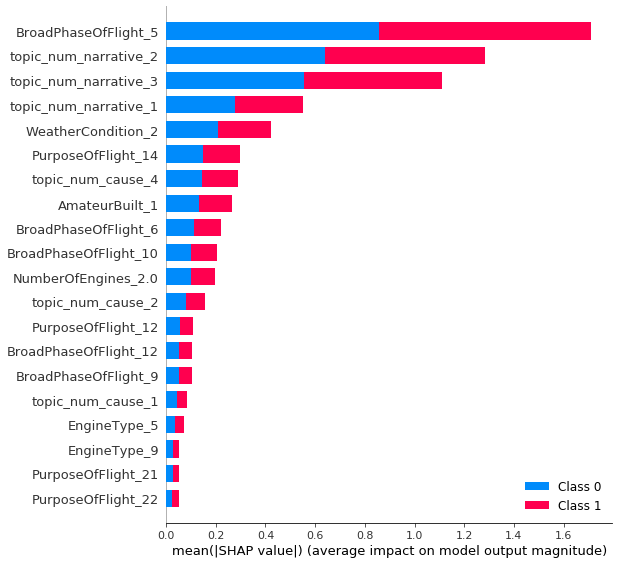

In [85]:
shap_values = shap.TreeExplainer(bst).shap_values(X_test)
shap.summary_plot(shap_values, X_test)